In [97]:
import logging
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
import pandas as pd
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
pd.set_option("display.float_format", lambda f: f"{f:,.2f}")

In [1]:
import ipywidgets as w

In [2]:
%matplotlib inline

## Buying

In [92]:
from typing import NamedTuple

from ipywidgets import fixed, interact, interact_manual, interactive

In [156]:
@interact(
    interest_rate=(0.025, 0.08, 0.005),
    house_price=(600_000, 900_000, 50_000),
    hoa=(0, 300, 50),
    down_payment_percent=(0.2, 0.3, 0.01),
    buying_fee_percent=(0.04, 0.08, 0.005),
    sale_fee_percent=(0.04, 0.1, 0.01),
    loan_period_in_years=(15, 40, 5),
    ownership_period_in_years=(30, 50, 5),
    rent=(3000, 5000, 500),
    mu_stock=(0.05, 0.50, 0.01),
    sigma_stock=(0.20, 0.75, 0.05),
    mu_home=(0.01, 0.20, 0.01),
    sigma_home=(0.05, 0.20, 0.01),
    stock_home_corr=(0, 1, 0.05),
    seed=(0, 100, 1),
    ylimit=10_000_000,
)
def rent_or_buy(
    interest_rate,
    house_price,
    hoa,
    down_payment_percent,
    buying_fee_percent,
    sale_fee_percent,
    loan_period_in_years,
    ownership_period_in_years,
    rent,
    mu_stock,
    sigma_stock,
    mu_home,
    sigma_home,
    stock_home_corr,
    seed,
    ylimit,
):
    down_payment = house_price * down_payment_percent
    principal = house_price - down_payment
    buying_fees = principal * buying_fee_percent

    loan_period_in_months = 12 * loan_period_in_years

    full_time_period_in_years = max(ownership_period_in_years, loan_period_in_years)
    full_time_period_in_months = full_time_period_in_years * 12

    monthly_interest_rate = interest_rate / 12
    mortgage_payment = npf.pmt(monthly_interest_rate, loan_period_in_months, principal)

    # cov = rho * sigma_1 * ... * sigma_n
    cov = stock_home_corr * sigma_stock * sigma_home
    cov_mat = np.array([[sigma_stock**2, cov], [cov, sigma_home**2]])

    data = np.random.default_rng(seed).multivariate_normal(
        [mu_stock, mu_home],
        cov_mat,
        full_time_period_in_months,
        check_valid="raise",
    )

    returns_df = pd.DataFrame(data, columns=["stock_apprec", "home_apprec"])
    returns_df /= 12

    cumulative_returns = returns_df.add(1).cumprod().reset_index(names=["period"])

    returns = pd.melt(
        cumulative_returns,
        id_vars="period",
        value_name="appreciation",
        var_name="asset_type",
    )

    home_perf = cumulative_returns.home_apprec
    stock_perf = cumulative_returns.stock_apprec
    after_payoff_stock_perf = stock_perf.shift(loan_period_in_months).fillna(0)

    pad_length = int(
        full_time_period_in_months
        * (1 - loan_period_in_months / full_time_period_in_months)
    )

    loan_period = np.arange(1, loan_period_in_months + 1, dtype="int64")
    time_period = np.arange(1, full_time_period_in_months + 1, dtype="int64")
    princ_paid = npf.ppmt(
        monthly_interest_rate, loan_period, loan_period_in_months, principal
    )
    princ_paid = np.pad(princ_paid, (0, pad_length), constant_values=0)
    int_paid = npf.ipmt(
        monthly_interest_rate, loan_period, loan_period_in_months, principal
    )
    int_paid = np.pad(int_paid, (0, pad_length), constant_values=0)
    hoa_paid = np.full(full_time_period_in_months, fill_value=hoa).cumsum()

    home_val = house_price * home_perf
    bal_rem = principal + princ_paid.cumsum()
    sale_fees = home_val * sale_fee_percent

    # 2024-2025 tax rate for wake county
    # take the highest rate for max pessimalism: zebulon according to
    # https://www.ncdor.gov/2024-2025taxrateseffectivetaxratespdf/open
    wake_county_maximum_combined_effective_tax_rate = 0.010756
    prop_taxes = (home_val * wake_county_maximum_combined_effective_tax_rate) / 12

    reassessed = np.mod(time_period - 1, 8 * 12) == 0

    monthly_prop_tax = prop_taxes.where(reassessed).ffill()

    prop_tax_paid = monthly_prop_tax.cumsum()

    date = pd.date_range(
        start=datetime.today().date(), periods=full_time_period_in_months, freq="MS"
    )

    monthly_ins_cost = (
        0.005 * home_val / 12
    )  # insurance is 5% of the home value, might be overestimating
    maint_fees = (
        home_val * 0.01 / 12
    )  # 1% average cost of ownership (maintenance, etc.)

    reinvestment = np.pad(
        np.full(loan_period_in_months, fill_value=-mortgage_payment).cumsum(),
        (pad_length, 0),
        constant_values=0,
    ) * np.isclose(int_paid, 0.0)
    raw_reinvestment = reinvestment.copy()
    reinvestment *= after_payoff_stock_perf / 2.0

    df_own = pd.DataFrame(
        {
            "period": time_period,
            "date": date,
            # these go to zero
            "princ_paid": princ_paid,
            "int_paid": int_paid,
            "bal_rem": bal_rem,
            # forever costs
            "hoa_paid": hoa_paid,
            "prop_tax_paid": prop_tax_paid,
            "sale_fees": sale_fees,
            "maint_fees": maint_fees,
            "home_val": home_val,
            # take the mortgage payment and invest it in the stock market
            "raw_reinvestment": raw_reinvestment,
            "reinvestment": reinvestment,
            "own_profit": home_val
            - (
                hoa_paid
                + bal_rem
                + buying_fees
                + sale_fees
                + prop_tax_paid
                + monthly_ins_cost
                + maint_fees
            )
            + reinvestment,
        }
    )

    rent_paid = rent * 1.02 ** ((time_period - 1) % 12 == 0).cumsum()
    monthly_savings = (
        df_own[["princ_paid", "int_paid"]].sum(axis=1).mul(-1).add(hoa)
        - rent_paid
        + maint_fees
        + monthly_prop_tax
    )

    down_payment_invested = stock_perf * down_payment
    total_rent_paid = rent_paid.cumsum()
    df_rent = pd.DataFrame(
        {
            "period": time_period,
            "date": date,
            "down_payment_invested": down_payment_invested,
            "rent_paid": rent_paid,
            "total_rent_paid": total_rent_paid,
            "rent_profit": down_payment_invested
            - total_rent_paid
            + monthly_savings.cumsum(),
        }
    )

    merged = pd.merge(df_own, df_rent, on="date").melt(
        value_vars=["rent_profit", "own_profit"], id_vars="date", var_name="asset_type"
    )

    return display(
        ggplot(
            merged.loc[merged.value <= ylimit],
            aes("date", "value", color="factor(asset_type)"),
        )
        + geom_line()
        + scale_x_datetime(
            breaks=date_breaks(width="1 years"), labels=date_format("%Y")
        )
        + ylim(-10_000, ylimit)
        + theme_minimal()
        + theme(figure_size=(14, 6), axis_text_x=element_text(rotation=35, hjust=1)),
    )

interactive(children=(FloatSlider(value=0.05, description='interest_rate', max=0.08, min=0.025, step=0.005), I…

## NC Wake County Tax Rate Details

Example: https://www.ncdor.gov/taxes-forms/property-tax/how-calculate-tax-bill

In [84]:
# 2024-2025 tax rate for wake county
# take the highest rate for max pessimalism: zebulon according to
# https://www.ncdor.gov/2024-2025taxrateseffectivetaxratespdf/open
wake_county_maximum_combined_effective_tax_rate = 0.010756
prop_taxes = (home_val * wake_county_maximum_combined_effective_tax_rate) / 12
prop_taxes

0       842.66
1       849.05
2       853.72
3       855.34
4       854.35
        ...   
355   4,069.64
356   4,110.07
357   4,098.86
358   4,170.73
359   4,168.01
Name: home_apprec, Length: 360, dtype: float64

In [85]:
reassessed = np.mod(time_period - 1, 8 * 12) == 0

Look into homestead exemptions

In [86]:
monthly_prop_tax = prop_taxes.where(reassessed).ffill()

In [87]:
monthly_prop_tax

0       842.66
1       842.66
2       842.66
3       842.66
4       842.66
        ...   
355   3,195.56
356   3,195.56
357   3,195.56
358   3,195.56
359   3,195.56
Name: home_apprec, Length: 360, dtype: float64

In [88]:
prop_tax_paid = monthly_prop_tax.cumsum()
prop_tax_paid

0         842.66
1       1,685.33
2       2,527.99
3       3,370.66
4       4,213.32
         ...    
355   614,332.04
356   617,527.60
357   620,723.15
358   623,918.71
359   627,114.26
Name: home_apprec, Length: 360, dtype: float64

## Back to calcs …

In [89]:
date = pd.date_range(
    start=datetime.today().date(), periods=full_time_period_in_months, freq="MS"
)

In [90]:
monthly_ins_cost = (
    0.005 * home_val / 12
)  # insurance is 5% of the home value, might be overestimating
maint_fees = home_val * 0.01 / 12  # 1% average cost of ownership (maintenance, etc.)

In [91]:
reinvestment = np.pad(
    np.full(loan_period_in_months, fill_value=-mortgage_payment).cumsum(),
    (pad_length, 0),
    constant_values=0,
) * np.isclose(int_paid, 0.0)
raw_reinvestment = reinvestment.copy()
reinvestment *= after_payoff_stock_perf / 2.0
reinvestment

0     0.00
1     0.00
2     0.00
3     0.00
4     0.00
      ... 
355   0.00
356   0.00
357   0.00
358   0.00
359   0.00
Name: stock_apprec, Length: 360, dtype: float64

In [92]:
df_own = pd.DataFrame(
    {
        "period": time_period,
        "date": date,
        # these go to zero
        "princ_paid": princ_paid,
        "int_paid": int_paid,
        "bal_rem": bal_rem,
        # forever costs
        "hoa_paid": hoa_paid,
        "prop_tax_paid": prop_tax_paid,
        "sale_fees": sale_fees,
        "maint_fees": maint_fees,
        "home_val": home_val,
        # take the mortgage payment and invest it in the stock market
        "raw_reinvestment": raw_reinvestment,
        "reinvestment": reinvestment,
        "own_profit": home_val
        - (
            hoa_paid
            + bal_rem
            + buying_fees
            + sale_fees
            + prop_tax_paid
            + monthly_ins_cost
            + maint_fees
        )
        + reinvestment,
    }
)
df_own

,period,date,princ_paid,int_paid,bal_rem,hoa_paid,prop_tax_paid,sale_fees,maint_fees,home_val,raw_reinvestment,reinvestment,own_profit
0,1,2025-03-01,-597.37,"-3,579.33","660,202.63",70,842.66,"65,808.64",783.44,"940,123.47",0.00,0.00,"185,592.38"
1,2,2025-04-01,-600.61,"-3,576.10","659,602.02",140,"1,685.33","66,307.63",789.38,"947,251.82",0.00,0.00,"191,900.78"
2,3,2025-05-01,-603.86,"-3,572.84","658,998.16",210,"2,527.99","66,672.25",793.72,"952,460.76",0.00,0.00,"196,429.78"
3,4,2025-06-01,-607.13,"-3,569.57","658,391.03",280,"3,370.66","66,798.25",795.22,"954,260.78",0.00,0.00,"197,796.02"
4,5,2025-07-01,-610.42,"-3,566.28","657,780.61",350,"4,213.32","66,720.95",794.30,"953,156.46",0.00,0.00,"196,468.14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,2054-10-01,"-4,065.40",-111.30,"16,483.01",24920,"614,332.04","317,822.08","3,783.60","4,540,315.38",0.00,0.00,"3,534,650.85"
356,357,2054-11-01,"-4,087.42",-89.28,"12,395.59",24990,"617,527.60","320,980.16","3,821.19","4,585,430.92",0.00,0.00,"3,577,373.78"
357,358,2054-12-01,"-4,109.56",-67.14,"8,286.03",25060,"620,723.15","320,104.23","3,810.76","4,572,917.63",0.00,0.00,"3,566,596.07"
358,359,2055-01-01,"-4,131.82",-44.88,"4,154.20",25130,"623,918.71","325,717.33","3,877.59","4,653,104.64",0.00,0.00,"3,641,936.02"


## Rental Data

In [93]:
rent_paid = rent * 1.02 ** ((time_period - 1) % 12 == 0).cumsum()
monthly_savings = (
    df_own[["princ_paid", "int_paid"]].sum(axis=1).mul(-1).add(hoa)
    - rent_paid
    + maint_fees
    + monthly_prop_tax
)

In [94]:
monthly_savings

0     1,282.81
1     1,288.75
2     1,293.09
3     1,294.59
4     1,293.67
        ...   
355   3,074.73
356   3,112.33
357   3,101.90
358   3,168.72
359   3,166.19
Length: 360, dtype: float64

In [95]:
down_payment_invested = stock_perf * down_payment
total_rent_paid = rent_paid.cumsum()
df_rent = pd.DataFrame(
    {
        "period": time_period,
        "date": date,
        "down_payment_invested": down_payment_invested,
        "rent_paid": rent_paid,
        "total_rent_paid": total_rent_paid,
        "rent_profit": down_payment_invested
        - total_rent_paid
        + monthly_savings.cumsum(),
    }
)
df_rent.round(2)

,period,date,down_payment_invested,rent_paid,total_rent_paid,rent_profit
0,1,2025-03-01,"284,689.61","4,590.00","4,590.00","281,382.41"
1,2,2025-04-01,"282,729.07","4,590.00","9,180.00","276,120.62"
2,3,2025-05-01,"296,344.46","4,590.00","13,770.00","286,439.10"
3,4,2025-06-01,"298,480.29","4,590.00","18,360.00","285,279.51"
4,5,2025-07-01,"301,747.85","4,590.00","22,950.00","285,250.74"
...,...,...,...,...,...,...
355,356,2054-10-01,"7,517,926.46","8,151.13","2,201,885.29","5,935,821.24"
356,357,2054-11-01,"7,732,083.88","8,151.13","2,210,036.42","6,144,939.86"
357,358,2054-12-01,"7,850,245.65","8,151.13","2,218,187.55","6,258,052.40"
358,359,2055-01-01,"8,141,410.99","8,151.13","2,226,338.68","6,544,235.34"


In [97]:
merged = pd.merge(df_own, df_rent, on="date").melt(
    value_vars=["rent_profit", "own_profit"], id_vars="date", var_name="asset_type"
)
merged

,date,asset_type,value
0,2025-03-01,rent_profit,"281,382.41"
1,2025-04-01,rent_profit,"276,120.62"
2,2025-05-01,rent_profit,"286,439.10"
3,2025-06-01,rent_profit,"285,279.51"
4,2025-07-01,rent_profit,"285,250.74"
...,...,...,...
715,2054-10-01,own_profit,"3,534,650.85"
716,2054-11-01,own_profit,"3,577,373.78"
717,2054-12-01,own_profit,"3,566,596.07"
718,2055-01-01,own_profit,"3,641,936.02"


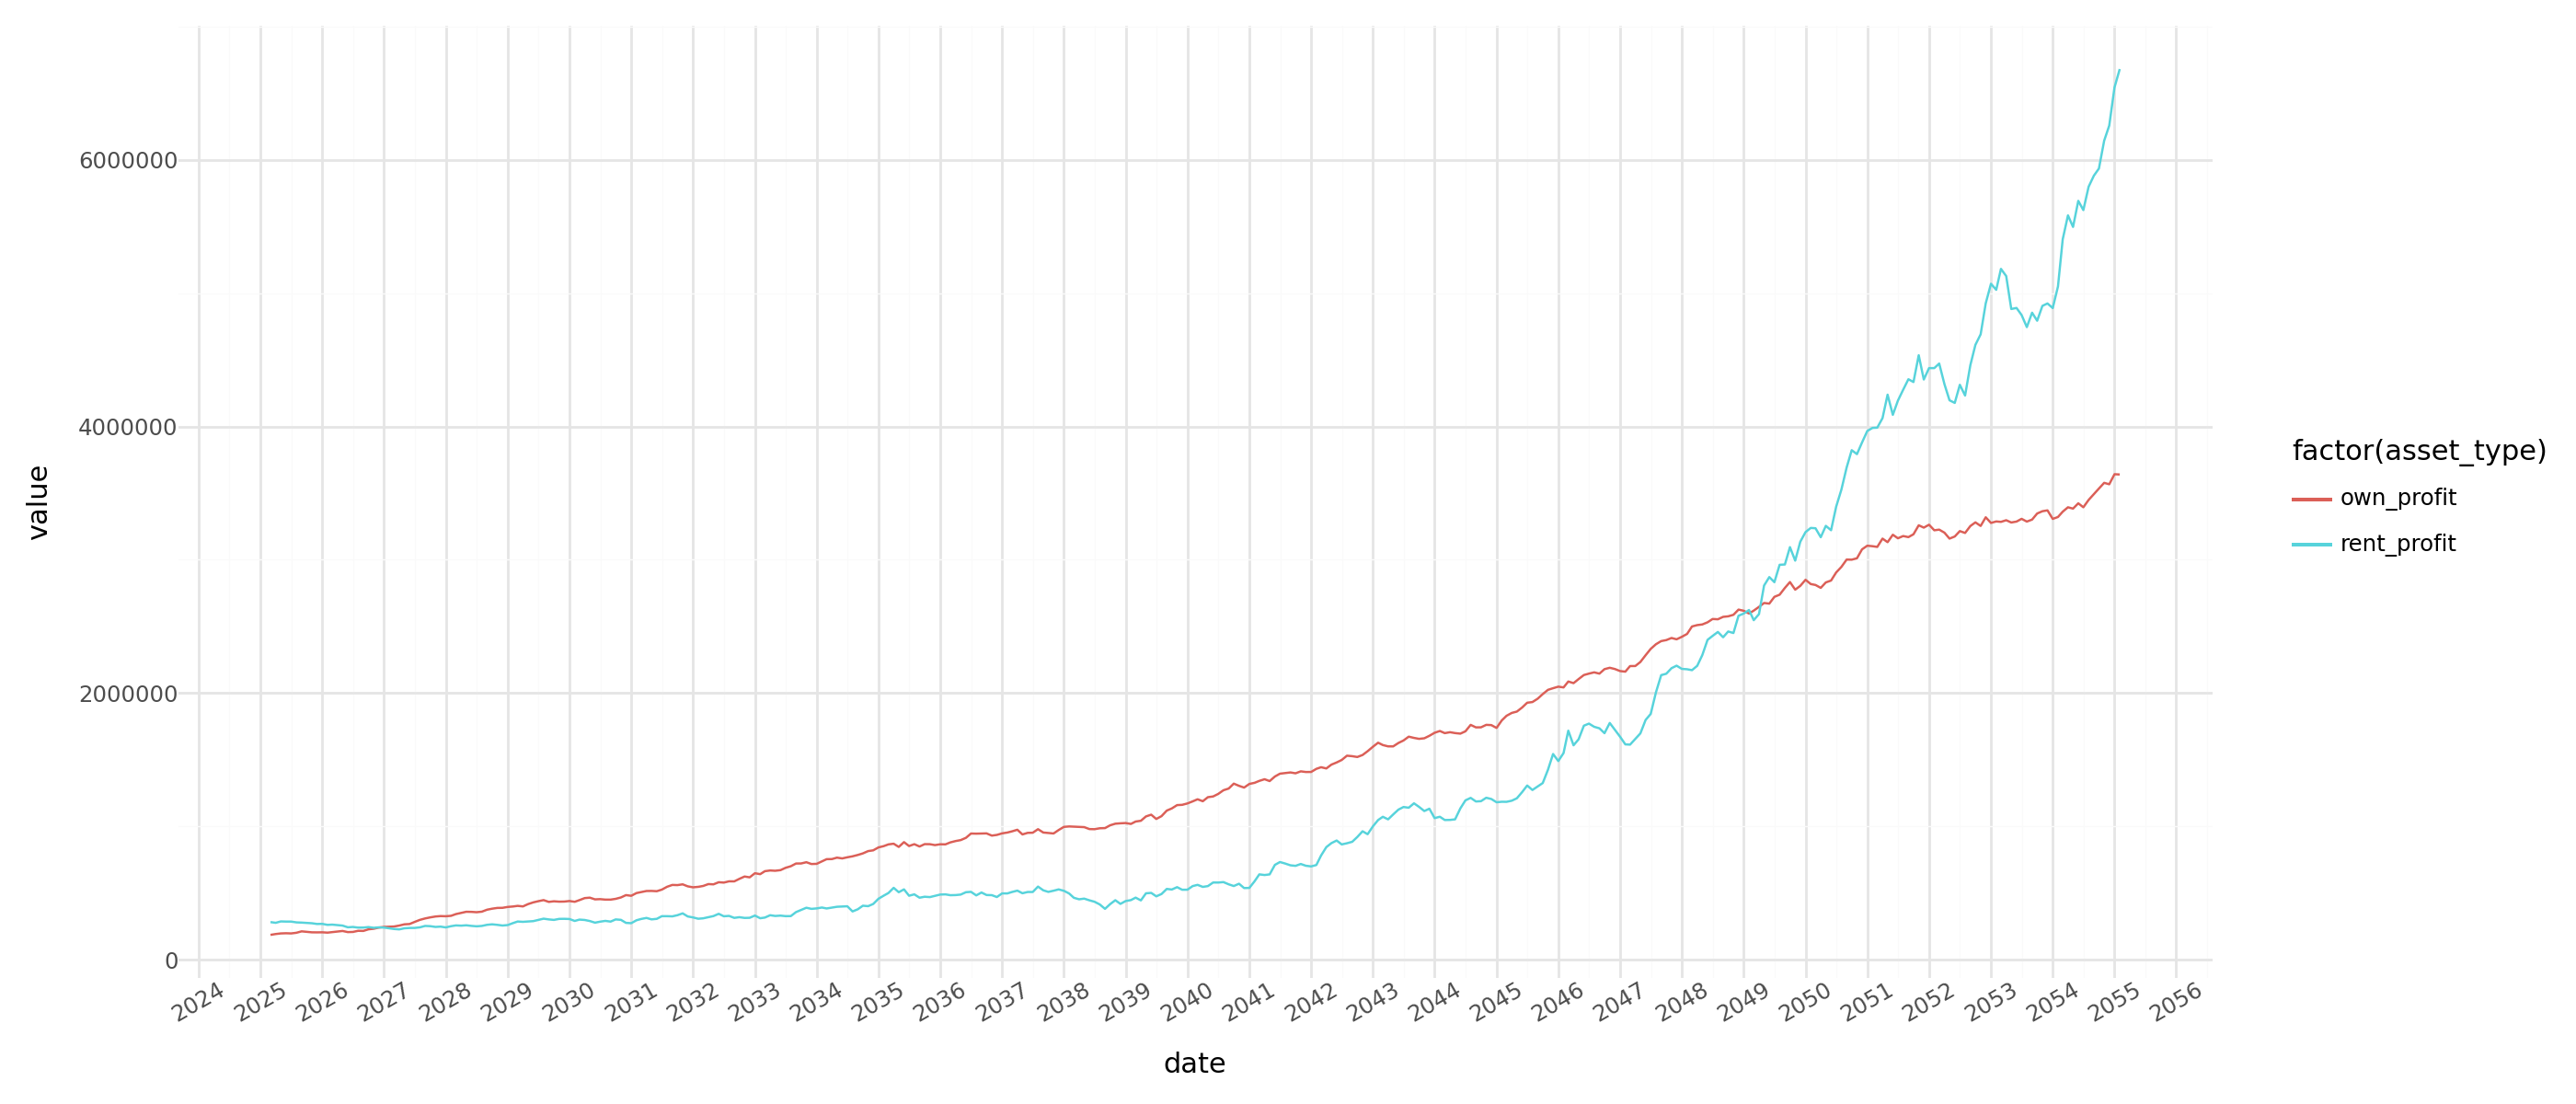

In [98]:
(
    ggplot(merged, aes("date", "value", color="factor(asset_type)"))
    + geom_line()
    + scale_x_datetime(breaks=date_breaks(width="1 years"), labels=date_format("%Y"))
    + theme_minimal()
    + theme(figure_size=(14, 6), axis_text_x=element_text(rotation=30))
)